 # **<font color='blue'/>Importation des packages et chargement des données**

---



Importation des packages

In [379]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

import datetime as dt
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib as mpl

from googletrans import Translator, constants

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.datasets import make_blobs

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import IsolationForest

import pickle as pk
import os

chargement des données df_olist_client

In [380]:
df_olist_client = pd.read_csv("df_olist_client.csv")

Convertir les colonne date en datetime

In [381]:
col_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
            'order_delivered_customer_date', 'order_estimated_delivery_date',
            'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

df_olist_client[col_date] = df_olist_client[col_date].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

# **<font color='blue'/>Segmentation RFM**

---


Définir la date de la dernière commande

In [382]:
latest_date = max(df_olist_client['order_purchase_timestamp']) + dt.timedelta(1)
latest_date = latest_date.strftime('%Y-%m-%d')
latest_date = datetime.strptime(latest_date , '%Y-%m-%d')
latest_date

datetime.datetime(2018, 9, 4, 0, 0)

Créer les scores de modélisation RFM pour chaque client 

In [383]:
RFM_scores = df_olist_client.groupby('customer_unique_id').agg({'order_purchase_timestamp' : lambda x:(latest_date - x.max()).days, 'nb_order' : lambda x : x, 'price' : lambda x:x})
RFM_scores

,order_purchase_timestamp,nb_order,price
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
ffff371b4d645b6ecea244b27531430a,573,1,89.90


Renomer les colonnes en Recency, Frequency, Monetary (RFM)

In [384]:
RFM_scores.rename(columns={'order_purchase_timestamp' : 'Recency',
                           'nb_order'                 : 'Frequency',
                           'price'                    : 'Monetary'}, inplace =True)

RFM_scores = RFM_scores.reset_index()
RFM_scores

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
95415,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
95416,ffff371b4d645b6ecea244b27531430a,573,1,89.90
95417,ffff5962728ec6157033ef9805bacc48,124,1,115.00


Convertir 'Recency' en type (int)

In [385]:
RFM_scores['Recency'] = RFM_scores['Recency'].astype(int)

Afficher Les statistiques descriptives 

In [386]:
RFM_scores.describe()

,Recency,Frequency,Monetary
count,95419.000000,95419.000000,95419.000000
mean,243.496494,1.034018,143.072014
std,153.153946,0.211235,218.880112
min,0.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.900000
75%,353.000000,1.000000,155.990000
max,729.000000,16.000000,13440.000000


Graphique de la distribution RFM


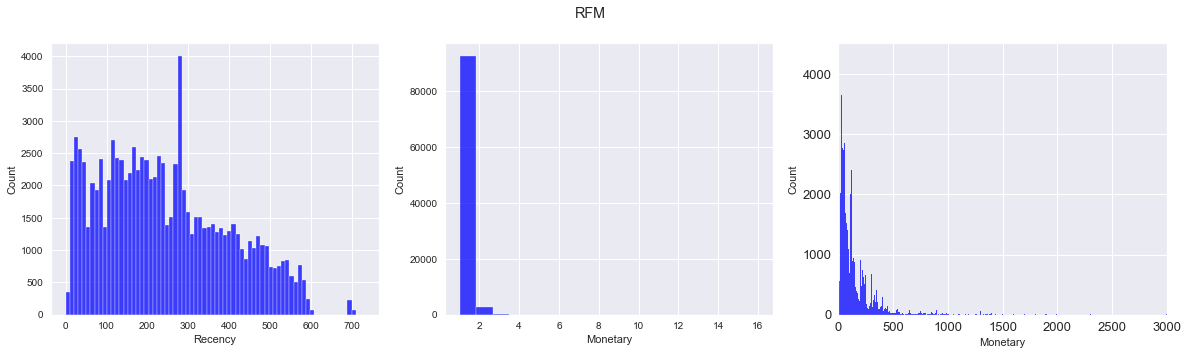

In [387]:
sns.set_style("darkgrid")

plt.figure(figsize=(20,5))

plt.subplot(131)
fig = sns.histplot(data=RFM_scores, x=RFM_scores['Recency'], color='blue')

fig.set_xlabel("Recency")

plt.subplot(132)
fig = sns.histplot(data=RFM_scores, x=RFM_scores['Frequency'], color='blue')
fig.set_xlabel("Frequency")

plt.subplot(133)
ax = sns.histplot(data=RFM_scores, x=RFM_scores['Monetary'], color='blue')
fig.set_xlabel("Monetary")
ax.set_xlim(0,3000)

plt.suptitle("RFM")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Graphique du distribution de la Récence


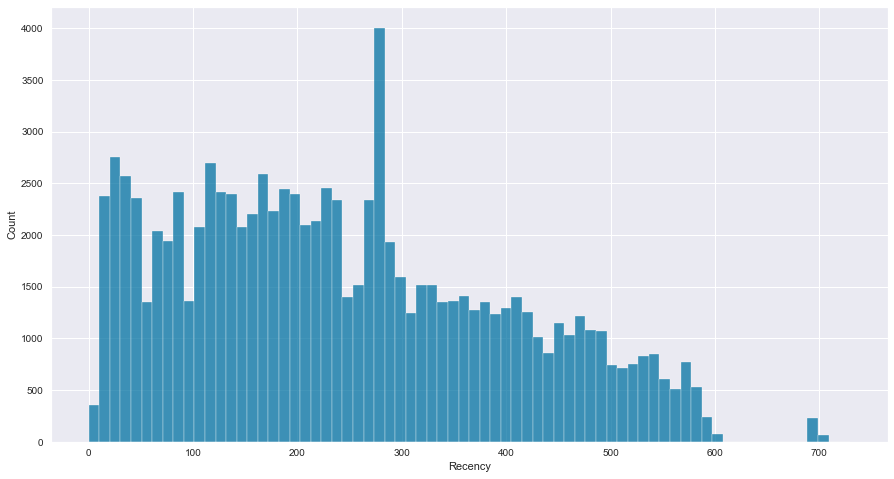

In [388]:
plt.figure(figsize=(15,8))

fig = sns.histplot(data=RFM_scores, x=RFM_scores['Recency'], palette='bright')

Graphique du distribution de la Fréquance


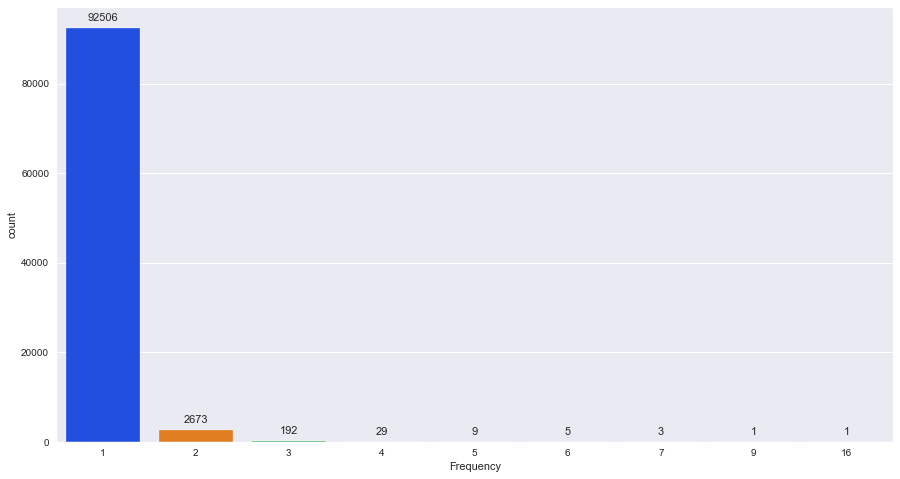

In [389]:
plt.figure(figsize=(15,8))

x = RFM_scores.query('Frequency < 20')['Frequency']
ax = sns.countplot(data=RFM_scores, x=x, palette='bright')

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

Graphique de la distribution de Monétaire


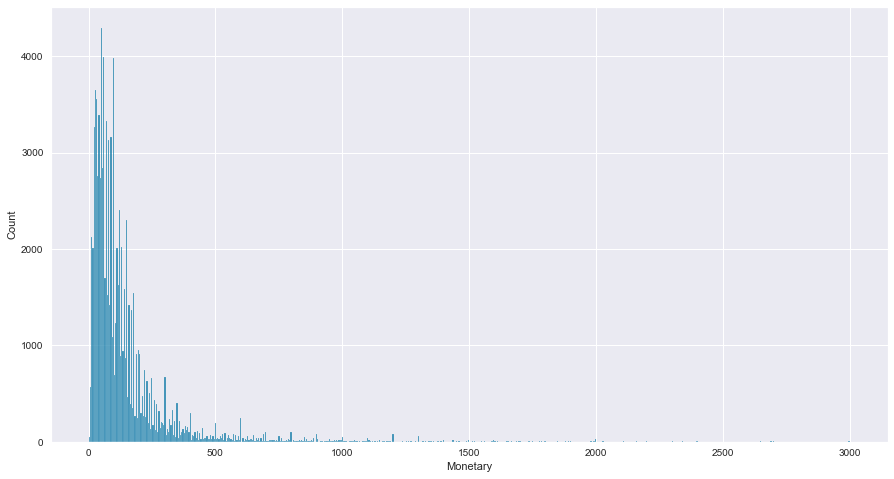

In [390]:
plt.figure(figsize=(15,8))

x = RFM_scores.query('Monetary < 3000')['Monetary']
fig = sns.histplot(data=RFM_scores, x=x, palette='bright')

Diviser les données en quatre segments à l'aide des quantiles

In [391]:
quantiles = RFM_scores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 119.0, 0.5: 224.0, 0.75: 353.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 47.9, 0.5: 89.9, 0.75: 155.99}}

Fonctions pour créer les segments R, F et M

In [392]:
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Calculer et ajouter des colonnes de segmentation R, F et M dans l'ensemble de données

In [393]:
RFM_scores['R'] = RFM_scores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFM_scores['F'] = RFM_scores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFM_scores['M'] = RFM_scores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFM_scores.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,4,4
2,0000f46a3911fa3c0805444483337064,542,1,69.00,4,4,3
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,4,4
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,4,1


Calculer et ajouter la colonne RFMGroup affichant le score concaténé combiné de RFM

In [394]:
RFM_scores['RFMGroup'] = RFM_scores.R.map(str) + RFM_scores.F.map(str) + RFM_scores.M.map(str)
RFM_scores

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,4,2,142
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,4,4,144
2,0000f46a3911fa3c0805444483337064,542,1,69.00,4,4,3,443
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,4,4,344
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,4,1,341
...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,4,4,1,441
95415,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,3,4,3,343
95416,ffff371b4d645b6ecea244b27531430a,573,1,89.90,4,4,3,443
95417,ffff5962728ec6157033ef9805bacc48,124,1,115.00,2,4,2,242


Calculer et ajouter la colonne  RFMScore affichant la somme totale des valeurs RFMGroup

In [395]:
RFM_scores['RFMScore'] = RFM_scores[['R', 'F', 'M']].sum(axis = 1)
RFM_scores.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,4,2,142,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,4,4,144,9
2,0000f46a3911fa3c0805444483337064,542,1,69.00,4,4,3,443,11
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,4,4,344,11
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,4,1,341,8


Attribuer un niveau de classification à chaque client pour différencier les bons et moins bons clients

In [396]:
# Classify_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
# Score_cuts = pd.qcut(RFM_scores.RFMScore, q = 4, labels = Classify_Level)
# RFM_scores['RFM_Classify_Level'] = Score_cuts.values
# RFM_scores.reset_index().head()

# **<font color='blue'/>Analyse en composantes principales ACP**

---

fusionner datafame RFM_scores avec df_olist_client 

In [397]:
df_olist_rfm = df_olist_client.merge(RFM_scores, on='customer_unique_id', how='left')
df_olist_rfm.shape

(95419, 36)

Les colonnes pour le PCA

In [398]:
col_pca = ['price', 'review_score' ,'nb_order', 'freight_value', 'Recency', 'Frequency', 'Monetary', 'RFMScore',
           'total_payment', 'nb_item', 'payment_sequential', 'nb_payment_installments']

Vérifier les valeurs manquantes

In [399]:
df_olist_rfm[col_pca].isna().sum()

price                      0
review_score               0
nb_order                   0
freight_value              0
Recency                    0
Frequency                  0
Monetary                   0
RFMScore                   0
total_payment              0
nb_item                    0
payment_sequential         0
nb_payment_installments    0
dtype: int64

In [400]:
df_olist_rfm[col_pca].head()

,price,review_score,nb_order,freight_value,Recency,Frequency,Monetary,RFMScore,total_payment,nb_item,payment_sequential,nb_payment_installments
0,129.90,5,1,12.00,116,1,129.90,7,141.90,1,1.0,8.0
1,18.90,4,1,8.29,119,1,18.90,9,27.19,1,1.0,1.0
2,69.00,3,1,17.22,542,1,69.00,11,86.22,1,1.0,8.0
3,25.99,4,1,17.63,326,1,25.99,11,43.62,1,1.0,4.0
4,180.00,5,1,16.89,293,1,180.00,8,196.89,1,1.0,6.0


In [401]:
df_olist_rfm[col_pca].describe()

,price,review_score,nb_order,freight_value,Recency,Frequency,Monetary,RFMScore,total_payment,nb_item,payment_sequential,nb_payment_installments
count,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000
mean,143.072014,4.100504,1.034018,23.726306,243.496494,1.034018,143.072014,8.917585,166.070491,1.187510,1.044823,2.889681
std,218.880112,1.321333,0.211235,23.190990,153.153946,0.211235,218.880112,1.727628,228.341907,0.651682,0.376884,2.679166
min,0.850000,1.000000,1.000000,0.000000,0.000000,1.000000,0.850000,3.000000,9.590000,1.000000,1.000000,0.000000
25%,47.900000,4.000000,1.000000,14.090000,119.000000,1.000000,47.900000,8.000000,63.100000,1.000000,1.000000,1.000000
50%,89.900000,5.000000,1.000000,17.600000,224.000000,1.000000,89.900000,9.000000,107.950000,1.000000,1.000000,2.000000
75%,155.990000,5.000000,1.000000,25.580000,353.000000,1.000000,155.990000,10.000000,183.270000,1.000000,1.000000,4.000000
max,13440.000000,5.000000,16.000000,1794.960000,729.000000,16.000000,13440.000000,12.000000,13664.080000,24.000000,29.000000,24.000000


Transformer les données en array numpy

In [402]:
X = df_olist_rfm[col_pca].values

Standardiser les données

In [403]:
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

Créer un modèle PCA

In [404]:
pca = PCA(n_components=len(col_pca), random_state=0)
pca.fit(X_scaled)

PCA(n_components=12, random_state=0)

Projeter X sur les composantes principales

In [405]:
X_reduc = pca.fit_transform(X_scaled)

Graphique des deux premières composantes

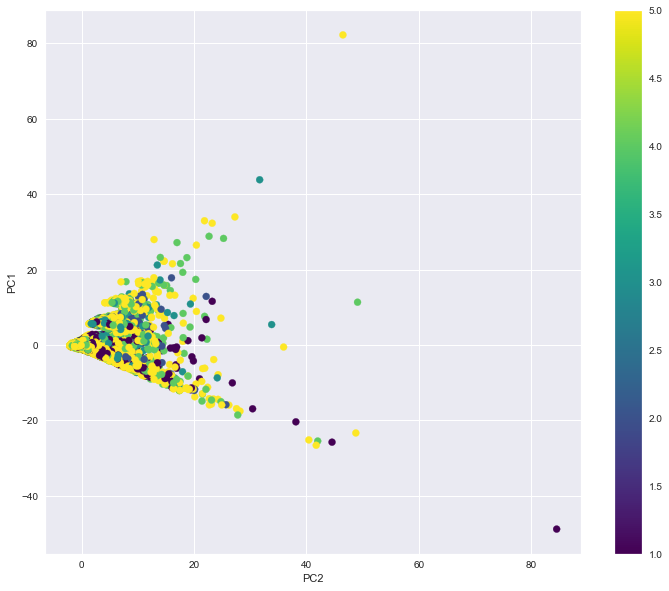

In [406]:
fig = plt.figure(figsize=(12,10))
sequence_of_colors = ["red", "orange", "yellow", "green", "blue"]
plt.scatter(X_reduc[:,0], X_reduc[:,1],c=df_olist_rfm['review_score'],cmap="viridis")
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.colorbar()

***Remarque :***

On constate la présence des anomalies ou valeurs aberrantes.

On va utiliser le modèle IsolationForest pour les détecter et ensuite les supprimer.

Instancier et entraîner le modèle pour détecter les anomalies ou les valeurs aberrantes (environ 1%)

In [407]:
# Créer une copie du dataframe df_olist_rfm
df_outlier = df_olist_rfm.copy()

model = IsolationForest(contamination=0.01, random_state=0)
model.fit(df_outlier[col_pca])

C:\Users\sweet\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.01, random_state=0)

Affecter les valeurs aberrantes

In [408]:
outlier = model.predict(df_outlier[col_pca]) == -1
df_outlier[outlier]

,customer_unique_id,price,order_status,customer_zip_code_prefix,customer_city,customer_state,review_score,freight_value,product_category_name,product_category_name_english,...,nb_item,nb_order,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
224,0096c18412349537abc45e350581cbbc,679.60,delivered,93310,novo hamburgo,RS,1,90.64,utilidades_domesticas,housewares,...,4,1,538,1,679.60,4,4,1,441,9
259,00adeda9b742746c0c66e10d00ea1b74,2078.50,delivered,5650,sao paulo,SP,1,69.90,relogios_presentes,watches_gifts,...,2,1,300,1,2078.50,3,4,1,341,8
292,00c07da5ba0e07b4f248a3a373b07476,2258.00,delivered,44700,jacobina,BA,5,46.68,automotivo,auto,...,1,1,38,1,2258.00,1,4,1,141,6
422,011875f0176909c5cf0b14a9138bb691,3999.90,delivered,4559,sao paulo,SP,5,17.01,relogios_presentes,watches_gifts,...,1,1,534,1,3999.90,4,4,1,441,9
444,012a218df8995d3ec3bb221828360c86,1429.80,delivered,6550,pirapora do bom jesus,SP,4,80.58,automotivo,auto,...,2,2,77,2,1429.80,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95045,ff0ae98646e7bbb41cf0f0d3991fef98,2999.89,delivered,45820,eunapolis,BA,5,48.38,informatica_acessorios,computers_accessories,...,1,1,455,1,2999.89,4,4,1,441,9
95130,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00,delivered,17506,marilia,SP,5,227.66,artes,art,...,1,1,467,1,6499.00,4,4,1,441,9
95199,ff6c9c45f6cee4ec0785650b18322d73,1499.00,delivered,14810,araraquara,SP,5,69.72,ferramentas_jardim,garden_tools,...,1,1,47,1,1499.00,1,4,1,141,6
95406,fff5eb4918b2bf4b2da476788d42051c,1050.00,delivered,58407,campina grande,PB,5,1794.96,sinalizacao_e_seguranca,signaling_and_security,...,6,1,63,1,1050.00,1,4,1,141,6


Supprimer les valeurs aberrantes

In [409]:
df_olist_rfm.drop(df_outlier[outlier].index, inplace=True, axis=0)
df_olist_rfm[col_pca].shape

(94464, 12)

Transformer les données en array numpy

In [410]:
X = df_olist_rfm[col_pca].values

Standardiser les données

In [411]:
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

Créer un modèle PCA

In [412]:
pca = PCA(n_components=len(col_pca), random_state=0)
pca.fit(X_scaled)

PCA(n_components=12, random_state=0)

Le pourcentage de variance expliquée par chacune des composantes.

Text(0.5, 1.0, 'Le pourcentage de variance expliquée par chacune des composantes')

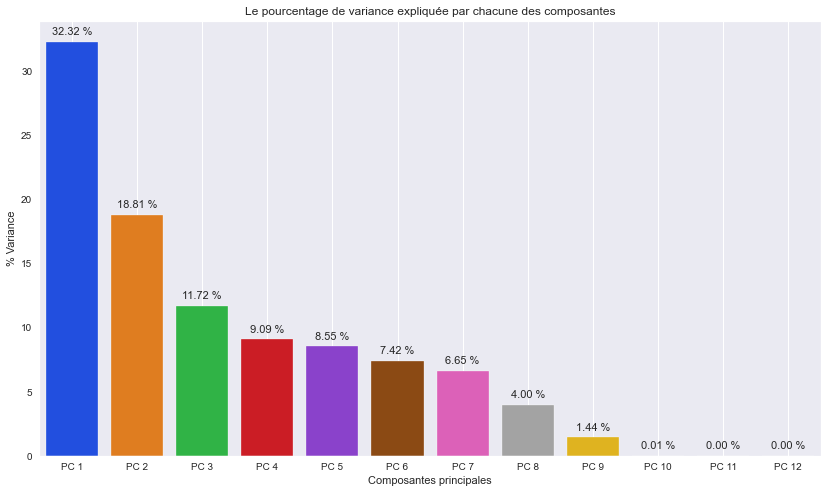

In [413]:
plt.figure(figsize=(14,8))

y = pca.explained_variance_ratio_
x = []
for i in range(len(y)):
  x.append('PC %s'%(i+1))

# afficher la variance en format pourcentage
y = y*100
ax = sns.barplot(x=x,y=y, palette='bright')

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.2f" % p.get_height() + ' %',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )
    
plt.grid()
plt.xlabel('Composantes principales')
plt.ylabel('% Variance')
plt.title('Le pourcentage de variance expliquée par chacune des composantes')
# pca.explained_variance_ratio_

Graphique de la variance et des composantes principales

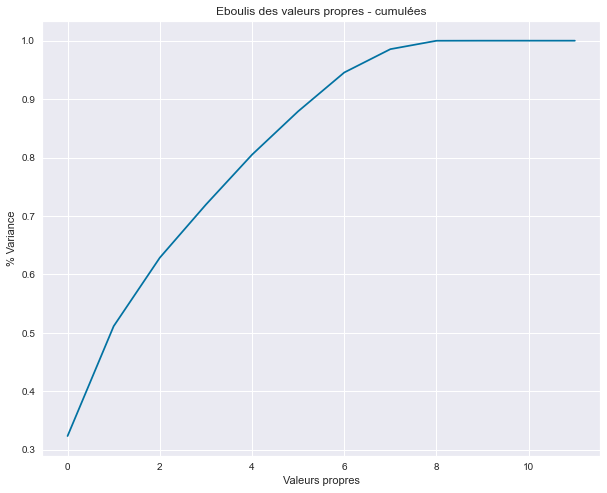

In [414]:
fig = plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('Valeurs propres')
plt.ylabel('% Variance')
plt.title('Eboulis des valeurs propres - cumulées')
plt.grid()

plt.show()

***Remarque*** :

On constate si on se fixe une proportion de variance expliquée de 94%, on peut se contenter de 7 composantes principales.

In [415]:
pca = PCA(n_components=7, random_state=0)
pca.fit(X_scaled)

PCA(n_components=7, random_state=0)

In [416]:
pca.n_components_

7

Le pourcentage de variance expliquée par chacune des composantes.

Text(0.5, 1.0, 'Le pourcentage de variance expliquée par chacune des composantes')

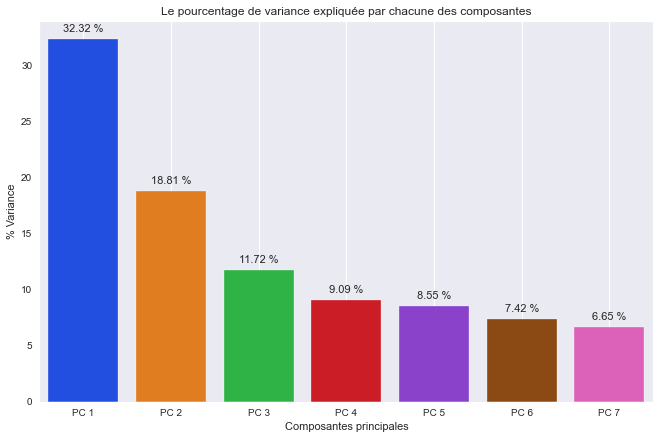

In [417]:
plt.figure(figsize=(11,7))

y = pca.explained_variance_ratio_
x = []
for i in range(len(y)):
  x.append('PC %s'%(i+1))

# afficher la variance en format pourcentage
y = y*100
ax = sns.barplot(x=x,y=y, palette='bright')

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.2f" % p.get_height() + ' %',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )
    
plt.grid()
plt.xlabel('Composantes principales')
plt.ylabel('% Variance')
plt.title('Le pourcentage de variance expliquée par chacune des composantes')
# pca.explained_variance_ratio_

La somme des pourcentages de variance

In [418]:
print(pca.explained_variance_ratio_.sum())

0.9455465282885642


Projeter X sur les composantes principales

In [419]:
X_reduc = pca.fit_transform(X_scaled)

In [420]:
X_reduc.shape

(94464, 7)

Graphique pour observer les composantes PC1 et PC2

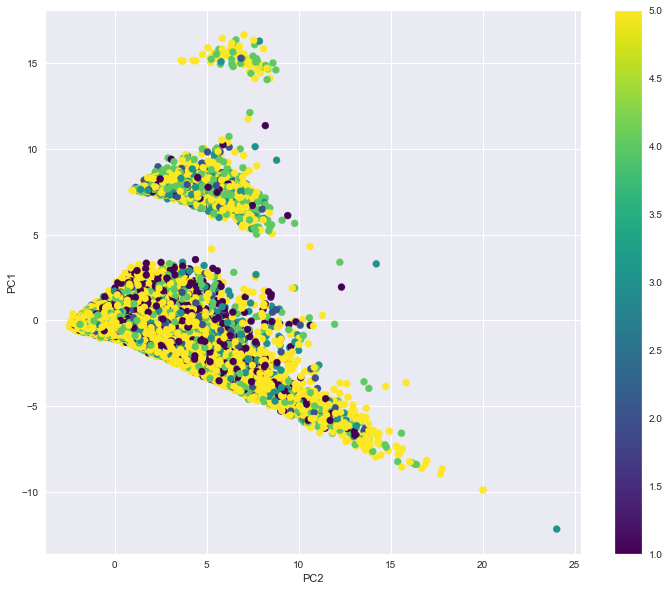

In [421]:
fig = plt.figure(figsize=(12,10))
plt.scatter(X_reduc[:,0], X_reduc[:,1],c=df_olist_rfm['review_score'],cmap="viridis")
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.colorbar()

***Remarque :***

Les données projetées sur les deux premières composantes principales et colorée par score.
Les bonnes performances (points jaunes)  et les moins bonnes (points bleus foncés).


# **<font color='blue'/>Segmentation K-Means**

---



Graphique pour identifier le nombre de clusters

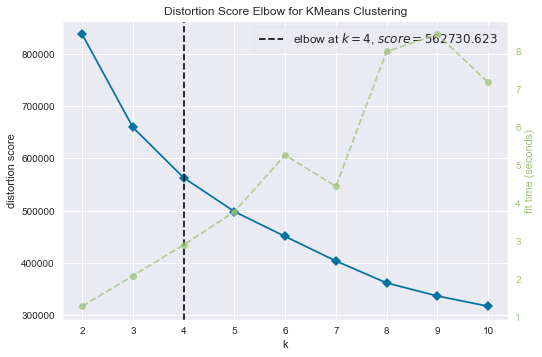

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [422]:
# Generate synthetic dataset with 8 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=0)

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(),K=(4,12))

visualizer.fit(X_reduc)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Initialiser l'objet

In [423]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit_transform(X_reduc)

array([[ 3.4335204 ,  9.63946298,  5.88562686,  2.16495817],
       [ 2.00133408,  9.89481096,  7.26678647,  1.71802698],
       [ 2.62240231, 10.4332759 ,  6.89195562,  3.86880823],
       ...,
       [ 1.5716904 , 10.24140828,  6.83896615,  3.49027237],
       [ 2.46634418,  9.55328483,  5.86449433,  1.1021725 ],
       [ 1.30099041, 10.22652122,  6.96993444,  3.15064793]])

La distance entre les clusters

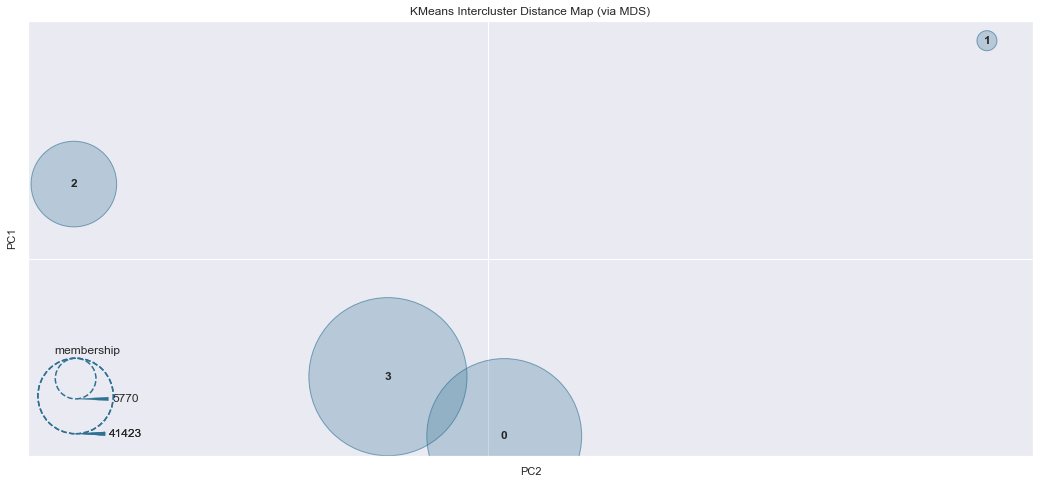

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [424]:
fig = plt.figure(figsize=(18,8))

K = visualizer.elbow_value_
distance_visualizer = InterclusterDistance(kmeans)
distance_visualizer.fit(X_reduc)
distance_visualizer.show()

Le nombre d'itérations nécessaires

In [425]:
kmeans.n_iter_

22

Trouver les clusters dans l'ensemble de données

In [426]:
df_olist_rfm['Cluster'] = kmeans.labels_
df_olist_rfm.head(5)

,customer_unique_id,price,order_status,customer_zip_code_prefix,customer_city,customer_state,review_score,freight_value,product_category_name,product_category_name_english,...,nb_order,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,delivered,7787,cajamar,SP,5,12.00,cama_mesa_banho,bed_bath_table,...,1,116,1,129.90,1,4,2,142,7,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,delivered,6053,osasco,SP,4,8.29,beleza_saude,health_beauty,...,1,119,1,18.90,1,4,4,144,9,3
2,0000f46a3911fa3c0805444483337064,69.00,delivered,88115,sao jose,SC,3,17.22,papelaria,stationery,...,1,542,1,69.00,4,4,3,443,11,0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,delivered,66812,belem,PA,4,17.63,telefonia,telephony,...,1,326,1,25.99,3,4,4,344,11,0
4,0004aac84e0df4da2b147fca70cf8255,180.00,delivered,18040,sorocaba,SP,5,16.89,telefonia,telephony,...,1,293,1,180.00,3,4,1,341,8,3


Grouper les clients par cluster pour analyser les moyennes :

In [427]:
kmeans_clusters_means = df_olist_rfm.groupby("Cluster").mean().reset_index()
kmeans_clusters_means

,Cluster,price,customer_zip_code_prefix,review_score,freight_value,product_photos_qty,seller_zip_code_prefix,payment_sequential,nb_payment_installments,total_payment,nb_item,nb_order,Recency,Frequency,Monetary,R,F,M,RFMScore
0,0,71.908273,35096.459407,4.155373,17.406624,2.216619,22913.600150,1.057673,2.331579,89.296102,1.070999,1.000000,358.021582,1.000000,71.908273,3.356638,4.000000,3.077372,10.434010
1,1,191.599211,32917.644371,4.155380,41.106149,2.117574,23760.523889,1.050270,3.024304,223.262796,2.402991,2.032821,228.721645,2.032821,191.599211,2.401329,1.003739,1.680100,5.085168
2,2,599.539754,39984.663258,3.924437,53.244170,2.444541,32462.250607,1.045407,5.861352,652.353567,1.486482,1.000000,251.170711,1.000000,599.539754,2.532236,4.000000,1.003813,7.536049
3,3,123.768097,34708.505773,4.081290,22.858500,2.210592,25109.785351,1.031451,2.960347,146.559101,1.142074,1.000000,137.993870,1.000000,123.768097,1.707895,4.000000,2.260877,7.968772


Les données kmeans_clusters_means standardisées

In [428]:
X_scaled_clusters = std_scale.fit_transform(kmeans_clusters_means[col_pca])
X_scaled_clusters = pd.DataFrame(X_scaled_clusters, index=kmeans_clusters_means[col_pca].index, columns=kmeans_clusters_means[col_pca].columns)
X_scaled_clusters["Cluster"] = kmeans_clusters_means['Cluster']
X_scaled_clusters

,price,review_score,nb_order,freight_value,Recency,Frequency,Monetary,RFMScore,total_payment,nb_item,payment_sequential,nb_payment_installments,Cluster
0,-0.840023,0.808712,-0.577350,-1.134874,1.456523,-0.577350,-0.840023,1.411498,-0.851831,-0.857234,1.198791,-0.888634,0
1,-0.264819,0.808792,1.732051,0.520545,-0.194833,1.732051,-0.264819,-1.407714,-0.246666,1.654283,0.425241,-0.381073,1
2,1.695639,-1.640521,-0.577350,1.368389,0.091875,-0.577350,1.695639,-0.115930,1.691657,-0.073828,-0.082861,1.697641,2
3,-0.590798,0.023017,-0.577350,-0.754059,-1.353565,-0.577350,-0.590798,0.112146,-0.593159,-0.723221,-1.541170,-0.427934,3


Comparaison des cluster (moyenne)

In [429]:
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)
couleur = ['red', 'green', 'blue', 'yellow']
# fig = go.Figure()
data = X_scaled_clusters
group = 'Cluster'
total_cutomer = df_olist_rfm['customer_unique_id'].size
r=0
c=0
for k in data[group]:
  r = r+1
  nb_cutomer = df_olist_rfm['customer_unique_id'][df_olist_rfm['Cluster']==k].size/total_cutomer * 100
  if(r<3):
    fig.add_trace(go.Scatterpolar(
        r=data[data[group]==k].iloc[:,:-1].values.reshape(-1),
        theta=data.columns[:-1],
        fill='toself',fillcolor=couleur[k], line=dict(color=couleur[k]),
        name='Cluster '+str(k)+'- Clients: '+str(np.round(nb_cutomer,2))+' %',
    ),1,r)
  else :
    c=c+1
    fig.add_trace(go.Scatterpolar(
        r=data[data[group]==k].iloc[:,:-1].values.reshape(-1),
        theta=data.columns[:-1],
        fill='toself',fillcolor=couleur[k], line=dict(color=couleur[k]),
        name='Cluster '+str(k)+'- Clients: '+str(np.round(nb_cutomer,2))+' %',
     ),2,c)
    

fig.update_layout(
    polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
    showlegend=True,
    title={
        'text': "Comparaison des moyennes par cluster",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font_color="blue",font_size = 12,width=1200,height=800,
    title_font_size=18)

fig.show()

Les clusters avec les composantes principales

In [430]:
kmeans_clusters_means = df_olist_rfm.groupby("Cluster").mean().reset_index()
kmeans_clusters_means['nb_customer'] = df_olist_rfm.groupby(['Cluster']).agg({"customer_unique_id" : "count"})

Colors = ["red", "green", "blue", 'yellow']

# kmeans_clusters_means['Color'] = kmeans_clusters_means['Cluster'].map(lambda p: Colors[p])

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = kmeans_clusters_means['Cluster'],
                    colorscale =[[0, 'red'], [0.3, 'green'], [0.6, 'blue'], [1.0, 'yellow']],
                    ),
        dimensions = list([
            dict(
                 label = "Cluster", values = kmeans_clusters_means['Cluster']),

            dict(
                 label = 'price', values = kmeans_clusters_means['price']),

            dict(
                 label = 'Score', values = kmeans_clusters_means['review_score']),

            dict(
                 label = 'Number of orders', values = kmeans_clusters_means['nb_order']),

            dict(
                 label = "Freight", values = kmeans_clusters_means['freight_value']),

            dict(
                 label = "Recency", values = kmeans_clusters_means['Recency']),

            dict(
                 label = 'Frequency', values = kmeans_clusters_means['Frequency']),

            dict(
                 label = 'Monetary', values = kmeans_clusters_means['Monetary']),

            dict(
                 label = "Number of items", values = kmeans_clusters_means['nb_item']),

            dict(
                 label = "sequential payment", values = kmeans_clusters_means['payment_sequential']),

            dict(
                 label = "installment payment", values = kmeans_clusters_means['nb_payment_installments']),
            
            dict(
                 label = "Number of customers", values = kmeans_clusters_means['nb_customer']),

            ]),
            
        )
    )

fig.update_layout(
    paper_bgcolor = 'white',
    title="Les clusters avec les composantes principales",
)


fig.show()

Vérifier les centroïdes

In [431]:
centroid = kmeans.cluster_centers_

Graphique 3D centroïdes

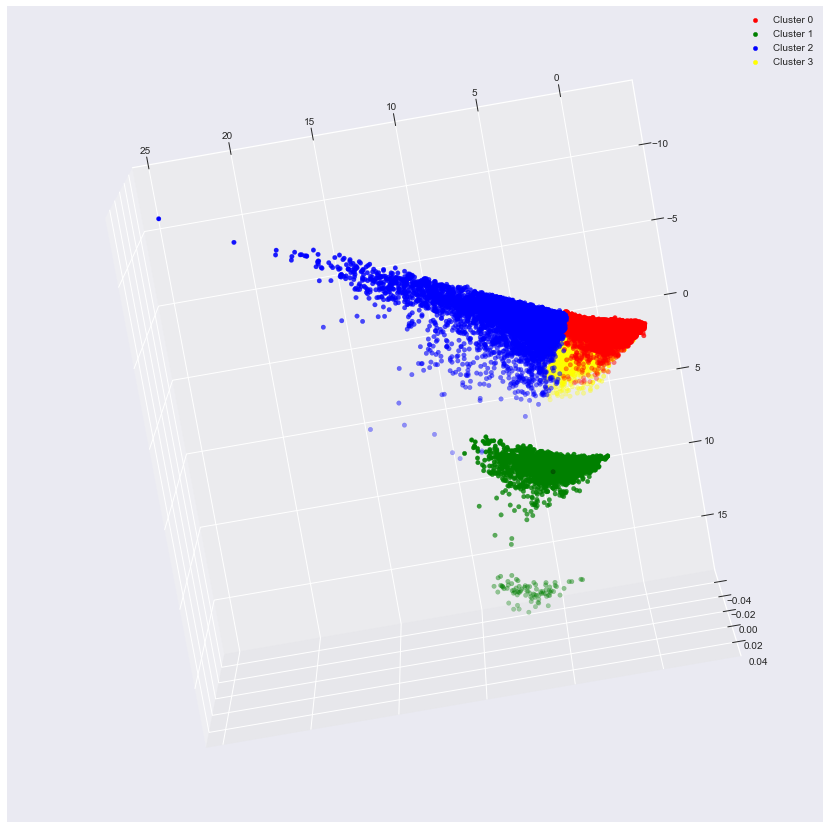

In [432]:
from numpy.core.fromnumeric import size
from mpl_toolkits.mplot3d import Axes3D # module 3D de Matplotlib

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d') # Création d'un objet "axe 3D"
# fig = plt.figure(figsize=(12,10))

Colors = ["red", "green", "blue", 'yellow', 'pink']

target_name = []
j=[]
for i in range(df_olist_rfm['Cluster'].unique().size):
  target_name.append('Cluster %s'%i)
  j.append(i)

df_olist_rfm['Color'] = df_olist_rfm['Cluster'].map(lambda p: Colors[p])

for color, i, target_name in zip(Colors, j, target_name):
  ax.scatter(X_reduc[df_olist_rfm['Cluster']==i,0], X_reduc[df_olist_rfm['Cluster']==i,1], color=color, label=target_name)

ax.view_init(100,80)
plt.legend()

ax.scatter(centroid[:,0], centroid[:,1], color='black')

Graphique 2D centroïdes

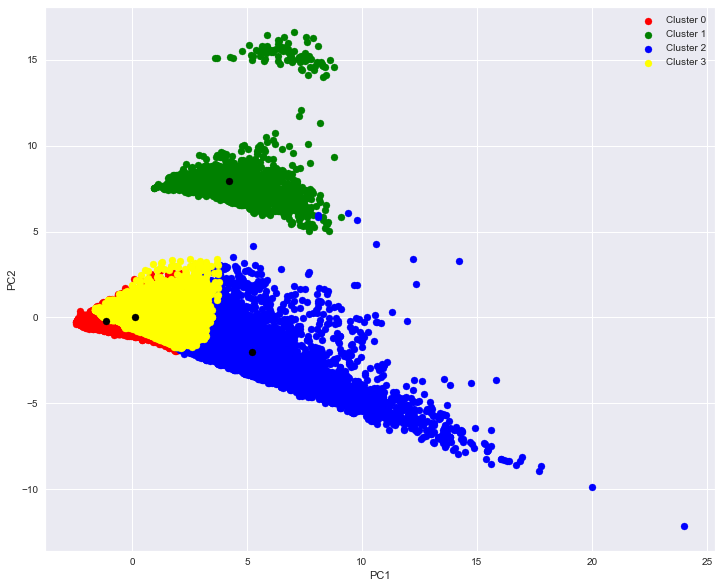

In [433]:
fig = plt.figure(figsize=(12,10))

Colors = ["red", "green", "blue", 'yellow', 'pink']

target_name = []
j=[]
for i in range(df_olist_rfm['Cluster'].unique().size):
  target_name.append('Cluster %s'%i)
  j.append(i)

df_olist_rfm['Color'] = df_olist_rfm['Cluster'].map(lambda p: Colors[p])

for color, i, target_name in zip(Colors, j, target_name):
  plt.scatter(X_reduc[df_olist_rfm['Cluster']==i,0], X_reduc[df_olist_rfm['Cluster']==i,1], color=color, label=target_name)

plt.legend()

# plt.scatter(y_kmeans[:,0], y_kmeans[:,1], c=df_olist_client['Color'])
plt.scatter(centroid[:,0], centroid[:,1], color='black')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

Graphique des scores par cluster

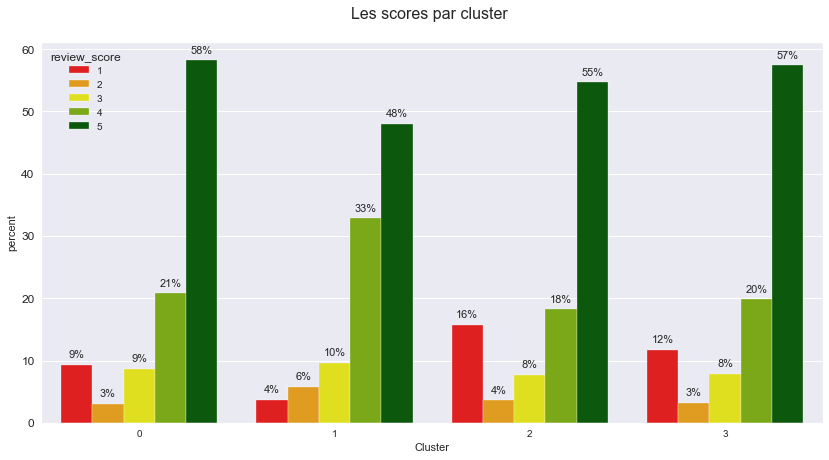

In [434]:
fig, ax = plt.subplots(figsize=(14, 7))

# colors = ['red', 'orange', 'yellow', 'orange', 'darkgreen']
palette ={1: "red", 2: "orange", 3: "yellow", 4: "#83c000", 5: "darkgreen"}

df_score_cluster = df_olist_rfm.groupby("Cluster")['review_score'].value_counts(normalize=True)
df_score_cluster = df_score_cluster.mul(100)
df_score_cluster = df_score_cluster.rename('percent').reset_index()

df_score_cluster = df_score_cluster.sort_values(by=['Cluster', 'review_score'])

ax = sns.barplot(x=df_score_cluster['Cluster'],y=df_score_cluster['percent'], 
                 data = df_score_cluster,hue='review_score', palette=palette)

# Ajouter des textes aux labels, titre etc.
ax.set_title("Les scores par cluster \n", fontsize=16)
ax.set_xlabel("Cluster")
plt.yticks(fontsize=12)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height()+'%',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )
    
plt.show()

Distribution pour chaque cluster

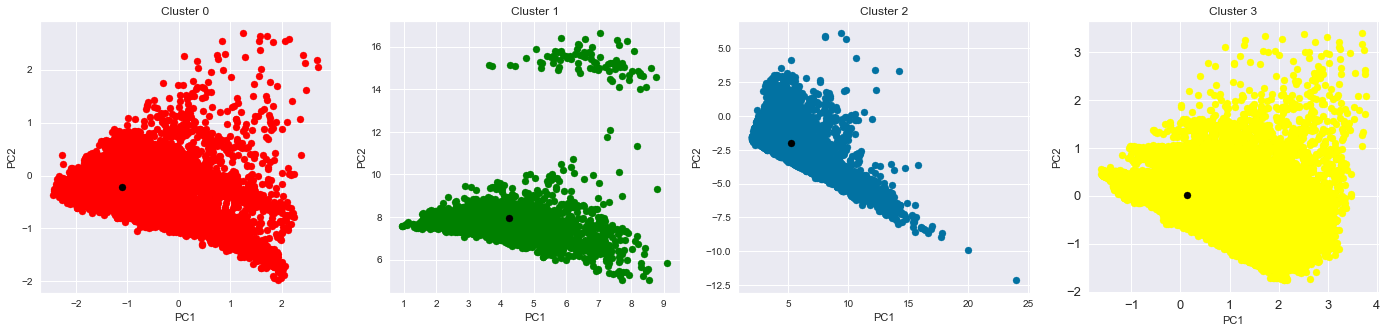

In [435]:
sns.set_style("darkgrid")

plt.figure(figsize=(24,5))

coleur = ['red', 'green', 'b', 'yellow']
subplot = 141
for i in data[group]:
  plt.subplot(subplot)
  plt.scatter(X_reduc[df_olist_rfm['Cluster']==i,0], X_reduc[df_olist_rfm['Cluster']==i,1], color=coleur[i])
  plt.scatter(centroid[:,0][i], centroid[:,1][i], color='black')
  plt.title("Cluster "+str(i))
  subplot+=1
  plt.xlabel('PC1')
  plt.ylabel('PC2')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

On peut obtenir les groupes prédits pour les données à l’aide de la méthode predict(X) :

In [436]:
pred = kmeans.predict(X_reduc)

Score ARI

In [437]:
# adjusted_rand_score(pred, df_olist_rfm['Cluster'].values)
adjusted_rand_score(pred, kmeans.labels_)

1.0

Prédire les clusters des valeurs aberrantes

In [438]:
df1_outlier = df_outlier[outlier].copy()

X_outlier = df1_outlier[col_pca].values
X_outlier_scaled  = std_scale.fit_transform(X_outlier)
X_outlier_reduc  = pca.fit_transform(X_outlier_scaled)
df1_outlier['Cluster'] = kmeans.predict(X_outlier_reduc)

Le nombre de clients par clusters

In [439]:
df1_outlier.groupby(['Cluster']).agg({"customer_unique_id" : "count"}).reset_index()

,Cluster,customer_unique_id
0,0,453
1,1,12
2,2,42
3,3,448


In [440]:
df1_outlier.shape

(955, 37)

Grouper les clients (outlisers) par cluster pour analyser les moyennes :

In [441]:
kmeans_outlier_means = df1_outlier.groupby("Cluster").mean().reset_index()
kmeans_outlier_means

,Cluster,price,customer_zip_code_prefix,review_score,freight_value,product_photos_qty,seller_zip_code_prefix,payment_sequential,nb_payment_installments,total_payment,nb_item,nb_order,Recency,Frequency,Monetary,R,F,M,RFMScore
0,0,651.910177,39526.728477,3.423841,146.780486,1.973510,26145.395143,1.048565,4.101935,727.701854,5.353201,2.326711,231.483444,2.326711,651.910177,2.379691,1.609272,1.03532,5.024283
1,1,6329.614167,40808.333333,3.500000,193.405000,2.333333,35903.583333,1.000000,4.416667,6523.021667,4.416667,1.333333,212.083333,1.333333,6329.614167,2.083333,3.500000,1.00000,6.583333
2,2,2686.954048,41931.333333,3.023810,69.640714,3.238095,23622.238095,1.071429,7.738095,2756.594762,1.261905,1.000000,486.285714,1.000000,2686.954048,3.904762,4.000000,1.00000,8.904762
3,3,1597.664643,40048.191964,3.725446,88.132500,2.435268,30265.131696,1.154018,6.698289,1667.331339,1.823661,1.345982,190.375000,1.345982,1597.664643,2.084821,3.022321,1.00000,6.107143


Exporter DataFrame df_olist_rfm au format CSV

In [442]:
df_olist_rfm.to_csv('df_olist_rfm.csv', index = False)

Sauvegarder et exporter les modèles PCA et K-Means

In [443]:
pk.dump(pca, open("pca.pkl","wb"))
pk.dump(kmeans, open("kmeans.pkl","wb"))